# Machine Learning Model using TensorFlow with Timeseries


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nrahfi","key":"d590799ea549819d02256987601dbc43"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d varpit94/tesla-stock-data-updated-till-28jun2021

  0% 0.00/58.6k [00:00<?, ?B/s]
100% 58.6k/58.6k [00:00<00:00, 45.6MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import zipfile
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
# Extract file zip
data_dir = "/content/"
zip_dir = f"{data_dir}tesla-stock-data-updated-till-28jun2021.zip"
zip = zipfile.ZipFile(zip_dir, 'r')
zip.extractall('/content')
zip.close()

In [ ]:
data = pd.read_csv(f"{data_dir}TSLA.csv")
data.head(len(data))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [ ]:
data.shape

(2956, 7)

In [ ]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
data = data.drop(columns=['High',	'Low',	'Close',	'Volume',	'Adj Close'], axis=1)

In [ ]:
data.head()

,Date,Open
0,2010-06-29,3.800
1,2010-06-30,5.158
2,2010-07-01,5.000
3,2010-07-02,4.600
4,2010-07-06,4.000


## Normalize Data and Create Plot

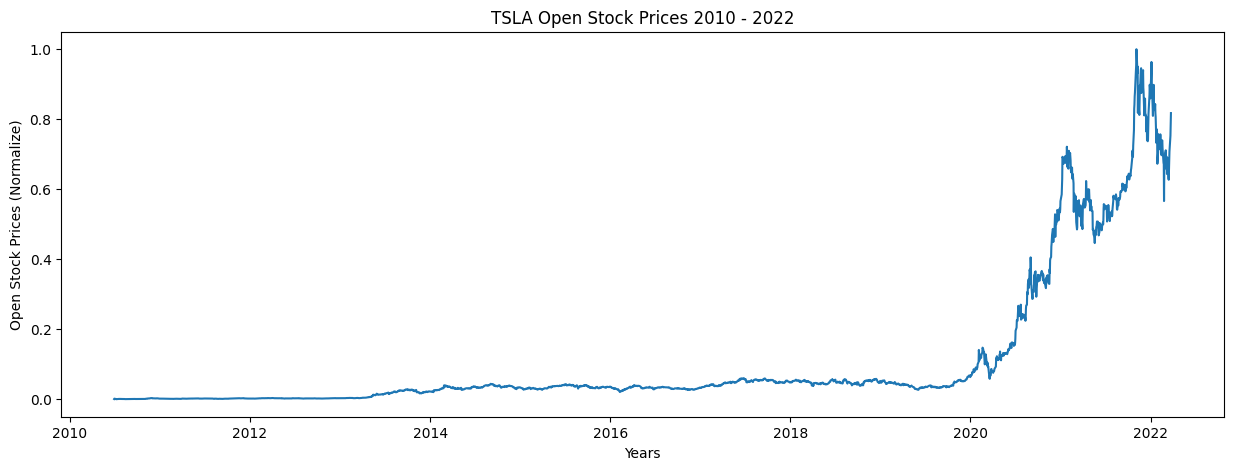

In [ ]:
scaler = MinMaxScaler()

data['Date'] = pd.to_datetime(data['Date'])
date = data['Date'].values
data['Open'] = scaler.fit_transform(np.array(data['Open']).reshape(-1, 1))
open = data['Open'].values

plt.figure(figsize=(15, 5))
plt.plot(date, open)
plt.title('TSLA Open Stock Prices 2010 - 2022')
plt.xlabel('Years')
plt.ylabel('Open Stock Prices (Normalize)')
plt.show()

In [ ]:
data.head(len(data))

,Date,Open
0,2010-06-29,0.000465
1,2010-06-30,0.001568
2,2010-07-01,0.001439
3,2010-07-02,0.001114
4,2010-07-06,0.000627
...,...,...
2951,2022-03-18,0.707663
2952,2022-03-21,0.740550
2953,2022-03-22,0.752750
2954,2022-03-23,0.793312


## Threshold MAE Value

In [ ]:
threshold_mae = (data['Open'].max() - data['Open'].min()) * 10/100
print(f"MAX: {data['Open'].max():.16f}\nMIN: {data['Open'].min():.16f}\nThreshold MAE: {threshold_mae:.16f}")

MAX: 1.0000000000000002
MIN: 0.0000000000000000
Threshold MAE: 0.1000000000000000


## Spliting Data & Train Model

In [ ]:
# Create Callback
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae):
      print("\nThe MAE is lower than the Threshold MAE!")
      self.model.stop_training = True
callbacks= Callback()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(open, date, test_size = 0.2, shuffle=False)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  data_series = tf.data.Dataset.from_tensor_slices(series)
  data_series = data_series.window(window_size + 1, shift=1, drop_remainder = True)
  data_series = data_series.flat_map(lambda w: w.batch(window_size + 1))
  data_series = data_series.shuffle(shuffle_buffer)
  data_series = data_series.map(lambda w: (w[:-1], w[-1:]))
  return data_series.batch(batch_size).prefetch(1)

In [ ]:
data_training = windowed_dataset(x_train, window_size=64, batch_size=128, shuffle_buffer=1000)
data_testing = windowed_dataset(x_test, window_size=64, batch_size=128, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizers = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizers,
              metrics=["mae"])

history = model.fit(
    data_training,
    epochs=50,
    validation_data=data_testing,
)

Epoch 1/50
18/18 [==============================] - 11s 266ms/step - loss: 5.8611e-04 - mae: 0.0284 - val_loss: 0.1601 - val_mae: 0.5082
Epoch 2/50
18/18 [==============================] - 4s 194ms/step - loss: 5.5621e-04 - mae: 0.0276 - val_loss: 0.1596 - val_mae: 0.5071
Epoch 3/50
18/18 [==============================] - 5s 251ms/step - loss: 5.3445e-04 - mae: 0.0269 - val_loss: 0.1591 - val_mae: 0.5062
Epoch 4/50
18/18 [==============================] - 4s 200ms/step - loss: 5.1450e-04 - mae: 0.0263 - val_loss: 0.1587 - val_mae: 0.5054
Epoch 5/50
18/18 [==============================] - 4s 210ms/step - loss: 4.9883e-04 - mae: 0.0258 - val_loss: 0.1583 - val_mae: 0.5046
Epoch 6/50
18/18 [==============================] - 5s 263ms/step - loss: 4.8345e-04 - mae: 0.0254 - val_loss: 0.1579 - val_mae: 0.5039
Epoch 7/50
18/18 [==============================] - 4s 211ms/step - loss: 4.6757e-04 - mae: 0.0251 - val_loss: 0.1576 - val_mae: 0.5033
Epoch 8/50
18/18 [=============================

## Model MAE & Model Loss


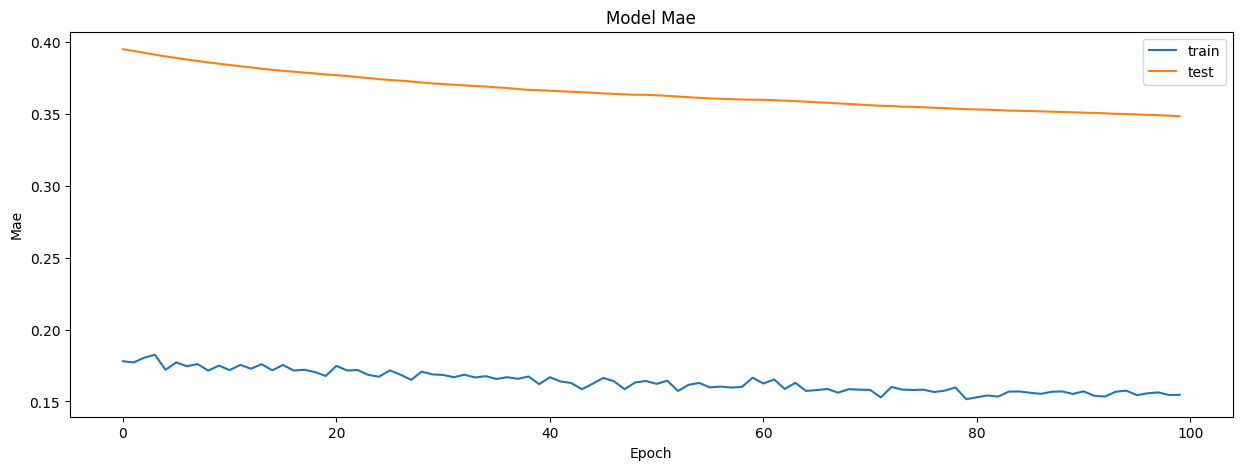

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

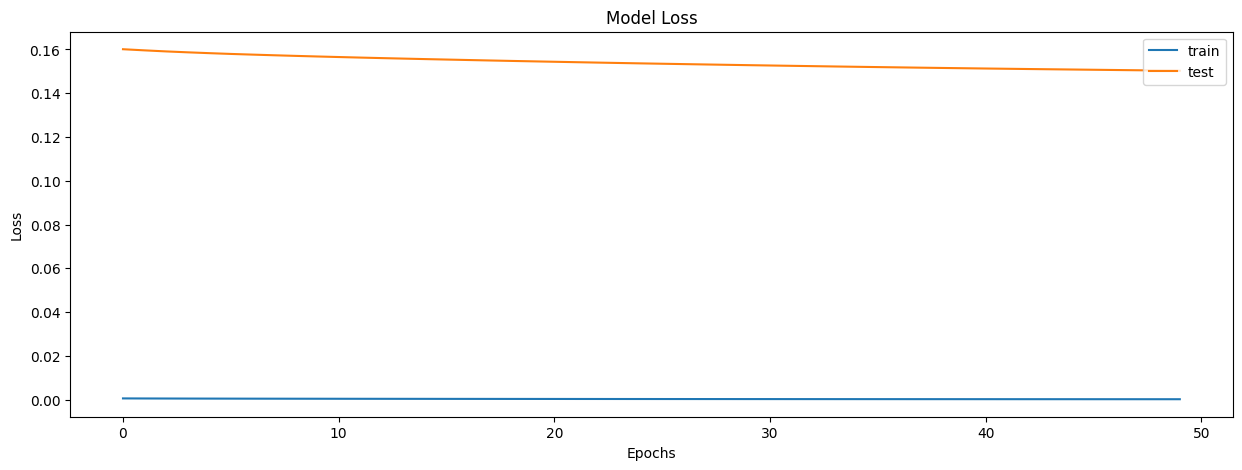

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()